In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Mount Drive once
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# Grab or cache GitHub PAT
import os, getpass, pathlib
token_file = pathlib.Path('/content/drive/My Drive/gh_token.txt')
if not token_file.exists():
    token_file.write_text(getpass.getpass("GitHub PAT: ").strip())
token = token_file.read_text().strip()

# One-time git config
!git config --global user.email "ok-web-4209@users.noreply.github.com"
!git config --global user.name  "ok-web-4209"

# Clone or pull the repo
%cd /content
!git clone https://{token}@github.com/ok-web-4209/PySpark-Analysis.git 2>/dev/null || echo "Repo already present."
%cd PySpark-Analysis
!git pull origin main

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GitHub PAT: ··········
/content
/content/PySpark-Analysis
From https://github.com/ok-web-4209/PySpark-Analysis
 * branch            main       -> FETCH_HEAD
Already up to date.


In [ ]:
!pip install -q praw
import praw

reddit = praw.Reddit(
    client_id     = "paste yours",
    client_secret = "paste yours",
    user_agent    = "PySpark-Analysis/0.1 by ok-web-4209"
)

print("✅ Connected")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 4.6 MB/s eta 0:00:00
✅ Connected


In [ ]:
import pyspark
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("Reddit-PySpark")
    .config("spark.sql.repl.eagerEval.enabled", True)  # nice for notebooks
    .getOrCreate()
)

print("Spark version:", spark.version)
print("✅ Spark session ready")

Spark version: 3.5.1
✅ Spark session ready


In [ ]:
SUBS = [
    "beermoneyglobal",
    "beermoneyuk",
    "DoneDirtCheap",
    "forhire",
    "freelance_forhire",
    "hiring",
    "Affiliatemarketing",
    "smallbusiness",
    "Business_Ideas",
    "SaaS",
    "startups"
]

# Quick connectivity check
for s in SUBS:
    try:
        sub = reddit.subreddit(s)
        print(f"✅  {sub.display_name}  ({sub.subscribers} subscribers)")
    except Exception as e:
        print(f"❌  {s}: {e}")

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅  beermoneyglobal  (199980 subscribers)
✅  beermoneyuk  (178359 subscribers)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅  DoneDirtCheap  (98129 subscribers)
✅  forhire  (513357 subscribers)
✅  freelance_forhire  (172809 subscribers)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅  hiring  (116797 subscribers)
✅  Affiliatemarketing  (235926 subscribers)
✅  smallbusiness  (2199365 subscribers)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅  Business_Ideas  (364009 subscribers)
✅  SaaS  (353577 subscribers)
✅  startups  (1879923 subscribers)


In [ ]:
# ------------------------------------------------------------------
# 1. Parameters & helper
# ------------------------------------------------------------------
SUBS = [
    "beermoneyglobal", "beermoneyuk", "DoneDirtCheap", "forhire",
    "freelance_forhire", "hiring", "Affiliatemarketing",
    "smallbusiness", "Business_Ideas", "SaaS", "startups"
]

import time, math
from datetime import datetime, timedelta, timezone

CUTOFF_UNIX = int((datetime.now(timezone.utc) - timedelta(weeks=7)).timestamp())

def fetch_posts(sub_name):
    """Return list of dicts for one subreddit"""
    sub = reddit.subreddit(sub_name)
    posts = []
    # ---- grab everything via sub.new(limit=None) ----
    for p in sub.new(limit=None):
        if p.created_utc < CUTOFF_UNIX:   # stop when we pass 7 weeks
            break
        posts.append({
            "subreddit":   sub_name,
            "title":       p.title,
            "author":      str(p.author),
            "created_utc": datetime.fromtimestamp(p.created_utc, tz=timezone.utc),
            "upvotes":     p.score,
            "num_comments": p.num_comments,
            "post_id":     p.id
        })
    return posts

# ------------------------------------------------------------------
# 2. Pull data for all subs
# ------------------------------------------------------------------
all_posts = []
for s in SUBS:
    print(f"Fetching r/{s} ...")
    all_posts.extend(fetch_posts(s))
print(f"Total posts collected: {len(all_posts)}")

# ------------------------------------------------------------------
# 3. Spark DataFrame & order
# ------------------------------------------------------------------
import pyspark.sql.functions as F
df = spark.createDataFrame(all_posts) \
          .orderBy(F.col("created_utc").desc())   # new → old

# ------------------------------------------------------------------
# 4. Persist to disk (Parquet)
# ------------------------------------------------------------------
out_path = "/content/PySpark-Analysis/data/posts_last7w"
df.write.mode("overwrite").parquet(out_path)

print(f"✅ Saved {df.count()} rows → {out_path}")

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Fetching r/beermoneyglobal ...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Fetching r/beermoneyuk ...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Fetching r/DoneDirtCheap ...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Fetching r/forhire ...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Fetching r/freelance_forhire ...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Fetching r/hiring ...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Fetching r/Affiliatemarketing ...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Fetching r/smallbusiness ...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Fetching r/Business_Ideas ...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Fetching r/SaaS ...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Fetching r/startups ...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Total posts collected: 7688
✅ Saved 7688 rows → /content/PySpark-Analysis/data/posts_last7w


In [ ]:
from pyspark.sql import functions as F

df = spark.read.parquet("/content/PySpark-Analysis/data/posts_last7w")

(df
 .groupBy("subreddit")
 .applyInPandas(
     lambda pdf: pdf.nlargest(5, "upvotes")[["subreddit", "title", "upvotes", "num_comments"]],
     schema="subreddit string, title string, upvotes int, num_comments int")
 .orderBy("subreddit", F.col("upvotes").desc())
 .show(truncate=False))

+------------------+-------------------------------------------------------------------------------------+-------+------------+
|subreddit         |title                                                                                |upvotes|num_comments|
+------------------+-------------------------------------------------------------------------------------+-------+------------+
|Affiliatemarketing|Just hit $13K/mo in commissions!!!                                                   |357    |118         |
|Affiliatemarketing|Get $60 per sale for my digital product (AI)                                         |65     |13          |
|Affiliatemarketing|Can you really make 300-500$ a month through affiliate ?                             |58     |179         |
|Affiliatemarketing|Is Google killing affiliate marketing sites?                                         |47     |59          |
|Affiliatemarketing|I WANT TO JOIN AFFILIATE PROGRAMS!                                                  

In [ ]:
from pyspark.sql import functions as F

df = spark.read.parquet("/content/PySpark-Analysis/data/posts_last7w")

(df
 .groupBy("subreddit")
 .applyInPandas(
     lambda pdf: pdf.nlargest(5, "upvotes")[["subreddit", "title", "upvotes", "num_comments"]],
     schema="subreddit string, title string, upvotes int, num_comments int")
 .orderBy("subreddit", F.col("upvotes").desc())
 .show(n=55, truncate=False))      # 11 subs × 5 = 55 rows, no truncation

+------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+------------+
|subreddit         |title                                                                                                                                                                                                                                               |upvotes|num_comments|
+------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+------------+
|Affiliatemarketing|Just hit $13K/mo in commissions!!!                                                                                     

In [ ]:
import re
from pyspark.sql import functions as F

df = spark.read.parquet("/content/PySpark-Analysis/data/posts_last7w")

keywords = [
    "website", "web", "dev", "webdev", "development", "developer",
    "frontend", "backend", "fullstack", "design",
    "html", "css", "javascript", "react", "vue", "angular",
    "node", "php", "laravel", "django", "flask",
    "nextjs", "gatsby", "wordpress", "shopify"
]

pattern = r'\b(?:' + '|'.join(map(re.escape, keywords)) + r')\b'

web_posts = (
    df
    .filter(F.lower(F.col("title")).rlike(pattern))
    .orderBy(F.col("subreddit"), F.col("created_utc").desc())
)

print("Total web-dev related posts:", web_posts.count())
web_posts.select("subreddit", "title", "upvotes", "num_comments") \
         .show(web_posts.count(), truncate=False)

Total web-dev related posts: 659
+------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+------------+
|subreddit         |title                                                                                                                                                                                                                                                                                               |upvotes|num_comments|
+------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import re
from pyspark.sql import functions as F

df = spark.read.parquet("/content/PySpark-Analysis/data/posts_last7w")

keywords = [
    "website", "web", "dev", "webdev", "development", "developer",
    "frontend", "backend", "fullstack", "design",
    "html", "css", "javascript", "react", "vue", "angular",
    "node", "php", "laravel", "django", "flask",
    "nextjs", "gatsby", "wordpress", "shopify"
]

pattern = r'\b(?:' + '|'.join(map(re.escape, keywords)) + r')\b'

web_posts = (
    df
    .filter(F.lower(F.col("title")).rlike(pattern))
    .withColumn(
        "label",
        F.when(F.lower(F.col("subreddit")).isin("forhire", "freelance_forhire"), "for_hire")
         .when(F.lower(F.col("subreddit")) == "hiring", "hiring")
         .otherwise("general")
    )
    .select(
        F.col("subreddit").alias("name_of_sub"),
        F.col("author").alias("name_of_author"),
        F.col("num_comments").alias("number_of_comments"),
        "label",
        F.col("upvotes").alias("number_of_upvotes"),
        F.col("created_utc").alias("date_posted")
    )
    .orderBy(F.col("date_posted").desc())      # new → old
)

print("Structured web-dev posts:", web_posts.count())
web_posts.show(web_posts.count(), truncate=False)

Structured web-dev posts: 659
+------------------+--------------------+------------------+--------+-----------------+-------------------+
|name_of_sub       |name_of_author      |number_of_comments|label   |number_of_upvotes|date_posted        |
+------------------+--------------------+------------------+--------+-----------------+-------------------+
|SaaS              |secret_star_is_lost |0                 |general |1                |2025-07-29 16:45:20|
|forhire           |Agent_Phantom       |1                 |for_hire|1                |2025-07-29 16:38:35|
|freelance_forhire |hasanabijoy         |0                 |for_hire|1                |2025-07-29 16:30:02|
|freelance_forhire |bro_bRisk3003       |0                 |for_hire|1                |2025-07-29 16:24:14|
|freelance_forhire |guywithnobeardT_T   |0                 |for_hire|1                |2025-07-29 16:24:02|
|forhire           |Criticism_Typical   |1                 |for_hire|2                |2025-07-29 16:19:11

In [ ]:
import re
from pyspark.sql import functions as F

df = spark.read.parquet("/content/PySpark-Analysis/data/posts_last7w")

keywords = [
    "website", "web", "dev", "webdev", "development", "developer",
    "frontend", "backend", "fullstack", "design",
    "html", "css", "javascript", "react", "vue", "angular",
    "node", "php", "laravel", "django", "flask",
    "nextjs", "gatsby", "wordpress", "shopify"
]

pattern = r'\b(?:' + '|'.join(map(re.escape, keywords)) + r')\b'

# Regex to capture the first [...] tag (case-insensitive, strip spaces)
tag_regex = r'(?i)\[([^\]]+)\]'

web_posts = (
    df
    .filter(F.lower(F.col("title")).rlike(pattern))
    .withColumn(
        "tag",
        F.regexp_extract(F.lower(F.col("title")), tag_regex, 1)
    )
    .withColumn(
        "label",
        F.when(F.col("tag").rlike(r'hiring'), "hiring")
         .when(F.col("tag").rlike(r'for ?hire'), "for_hire")
         .otherwise("general")
    )
    .select(
        F.col("subreddit").alias("name_of_sub"),
        F.col("author").alias("name_of_author"),
        F.col("num_comments").alias("number_of_comments"),
        F.col("tag"),
        "label",
        F.col("upvotes").alias("number_of_upvotes"),
        F.col("created_utc").alias("date_posted")
    )
    .orderBy(F.col("date_posted").desc())
)

print("Total web-dev posts with tags:", web_posts.count())
web_posts.show(web_posts.count(), truncate=False)

Total web-dev posts with tags: 659
+------------------+--------------------+------------------+------------------+--------+-----------------+-------------------+
|name_of_sub       |name_of_author      |number_of_comments|tag               |label   |number_of_upvotes|date_posted        |
+------------------+--------------------+------------------+------------------+--------+-----------------+-------------------+
|SaaS              |secret_star_is_lost |0                 |                  |general |1                |2025-07-29 16:45:20|
|forhire           |Agent_Phantom       |1                 |for hire          |for_hire|1                |2025-07-29 16:38:35|
|freelance_forhire |hasanabijoy         |0                 |for hire          |for_hire|1                |2025-07-29 16:30:02|
|freelance_forhire |bro_bRisk3003       |0                 |for hire          |for_hire|1                |2025-07-29 16:24:14|
|freelance_forhire |guywithnobeardT_T   |0                 |for hire        

In [ ]:
web_posts = (
    df
    .filter(F.lower(F.col("title")).rlike(pattern))
    .withColumn(
        "tag",
        F.regexp_extract(F.lower(F.col("title")), tag_regex, 1)
    )
    .withColumn(
        "label",
        F.when(F.col("tag").rlike(r'hiring'), "hiring")
         .when(F.col("tag").rlike(r'for ?hire'), "for_hire")
         .otherwise("general")
    )
    .select(
        F.col("subreddit").alias("name_of_sub"),
        F.col("title"),                     # ← added back
        F.col("author").alias("name_of_author"),
        F.col("num_comments").alias("number_of_comments"),
        F.col("tag"),
        "label",
        F.col("upvotes").alias("number_of_upvotes"),
        F.col("created_utc").alias("date_posted")
    )
    .orderBy(F.col("date_posted").desc())
)

web_posts.show(web_posts.count(), truncate=False)

+------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+------------------+------------------+--------+-----------------+-------------------+
|name_of_sub       |title                                                                                                                                                                                                                                                                                               |name_of_author      |number_of_comments|tag               |label   |number_of_upvotes|date_posted        |
+------------------+--------------------------------------------------------------------------------------------------------------------------------------------

Top 10 terms & counts:
       term  count
0      hire   1738
1    hiring   1083
2   promote    845
3  business    477
4      free    473
5   looking    415
6      need    348
7      help    312
8     video    311
9      saas    307


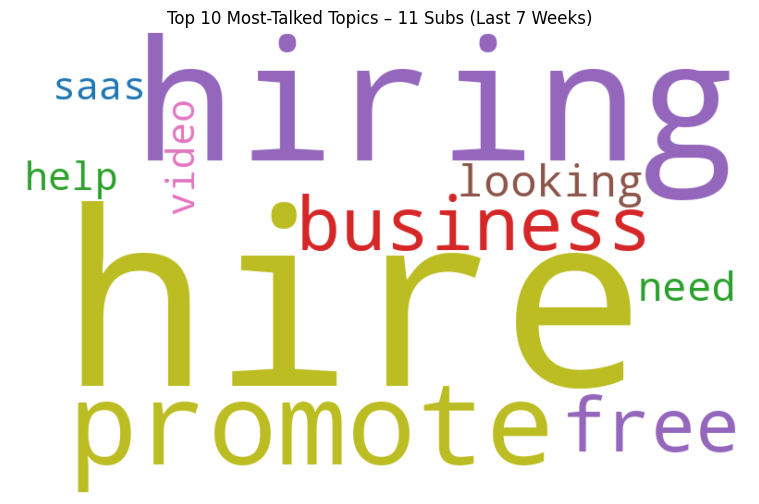

In [ ]:
# -----------------------------------------------------------
# 1.  Install lightweight deps (only once per VM)
# -----------------------------------------------------------
!pip install -q wordcloud nltk

# -----------------------------------------------------------
# 2.  Prep Spark-side tokenisation & counting
# -----------------------------------------------------------
import pyspark.sql.functions as F
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover

# Grab every title from the 11 subs (7-week dataset we already have)
titles_df = (
    spark.read.parquet("/content/PySpark-Analysis/data/posts_last7w")
         .select("title")
         .filter(F.col("title").isNotNull())
)

# Tokenise (keep only letters, drop punctuation & numbers)
tokenizer = RegexTokenizer(
    inputCol="title",
    outputCol="words",
    pattern=r"[^A-Za-z]+",
    minTokenLength=3
)

# Remove English stop-words
remover = StopWordsRemover(inputCol="words", outputCol="clean")

tokens = remover.transform(tokenizer.transform(titles_df))

# Count term frequencies
top_terms = (
    tokens
    .select(F.explode("clean").alias("term"))
    .groupBy("term")
    .count()
    .orderBy(F.col("count").desc())
    .limit(10)
    .toPandas()
)

print("Top 10 terms & counts:")
print(top_terms)

# -----------------------------------------------------------
# 3.  Build & display the word-cloud
# -----------------------------------------------------------
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create freq dict for WordCloud
freq_dict = dict(zip(top_terms.term, top_terms["count"]))

wc = WordCloud(
    width=800,
    height=500,
    background_color="white",
    colormap="tab10"
).generate_from_frequencies(freq_dict)

plt.figure(figsize=(10, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Top 10 Most-Talked Topics – 11 Subs (Last 7 Weeks)")
plt.show()

In [ ]:
!ls "/content/drive/MyDrive/" | grep -i spark